# Metabolomic Analysis of Extraction Rat Urine (C18 Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.10). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "~/Urin_Extraktion_Ratte/C18_pos", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Preparation_1_1", 5), rep("Preparation_1_2", 5), rep("Preparation_1_3", 5), 
                  rep("Preparation_2_1", 5), rep("Preparation_2_2", 5), rep("Preparation_2_3", 5), 
                  rep("Preparation_3_1", 5), rep("Preparation_3_2", 5), rep("Preparation_3_3", 5),
                  rep("Preparation_4_1", 5), rep("Preparation_4_2", 5),rep("Preparation_4_3", 5), rep("QC", 11))
sample.weight <- c(4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,
                   1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NA,NA, NA, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(54, 11, 62, 70, 23, 63, 17, 36, 51, 34, 55, 6, 31, 58, 14, 43, 25, 64, 44, 10, 42, 50, 61, 53, 
                  30, 33, 52, 40, 7, 9, 67, 69, 65, 46, 19, 28, 32, 45, 66, 22, 18, 39, 68, 24, 35, 37, 47, 8, 
                  20, 15, 56, 57, 48, 29, 59, 41, 21, 12, 26, 13, 1, 2, 3, 4, 5, 16, 27, 38, 49, 60, 71)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order,
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of TIC

In [4]:
## Define colours for experimental groups
group.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13])
names(group.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")

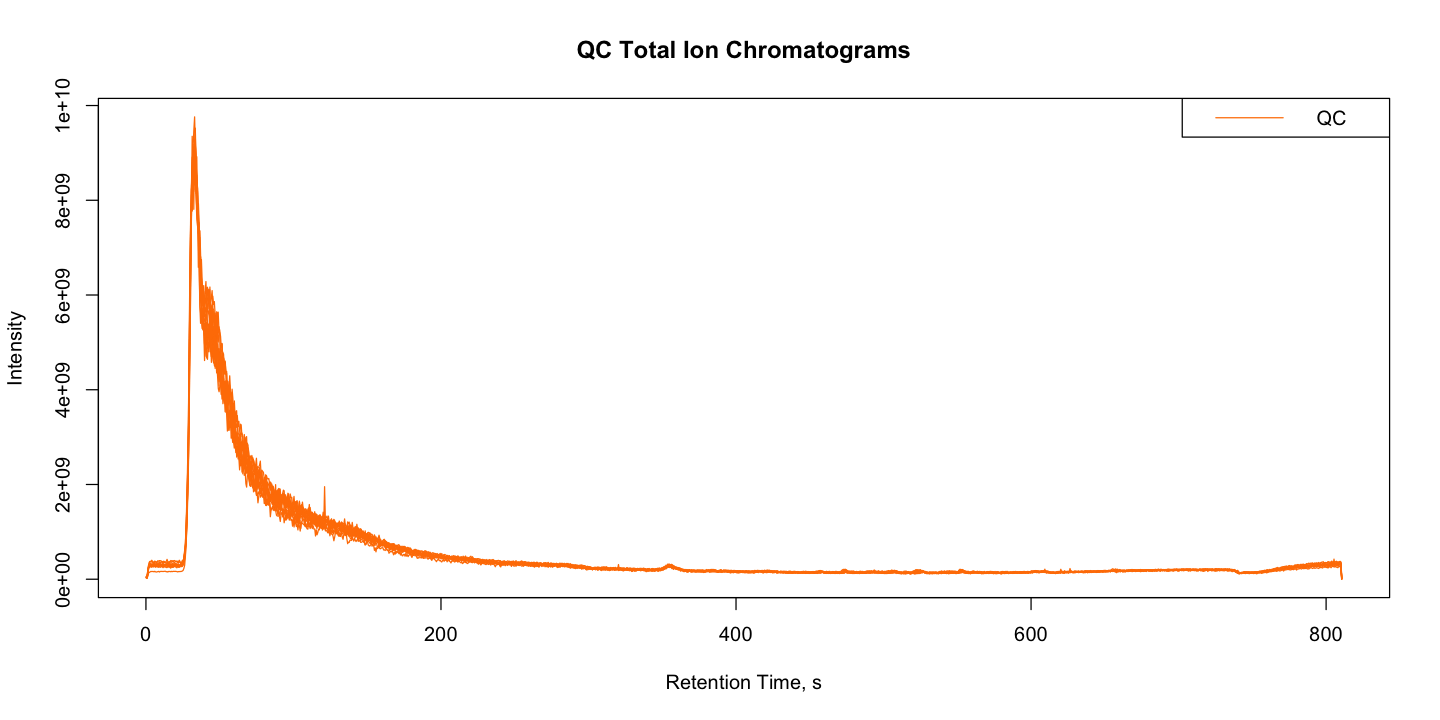

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

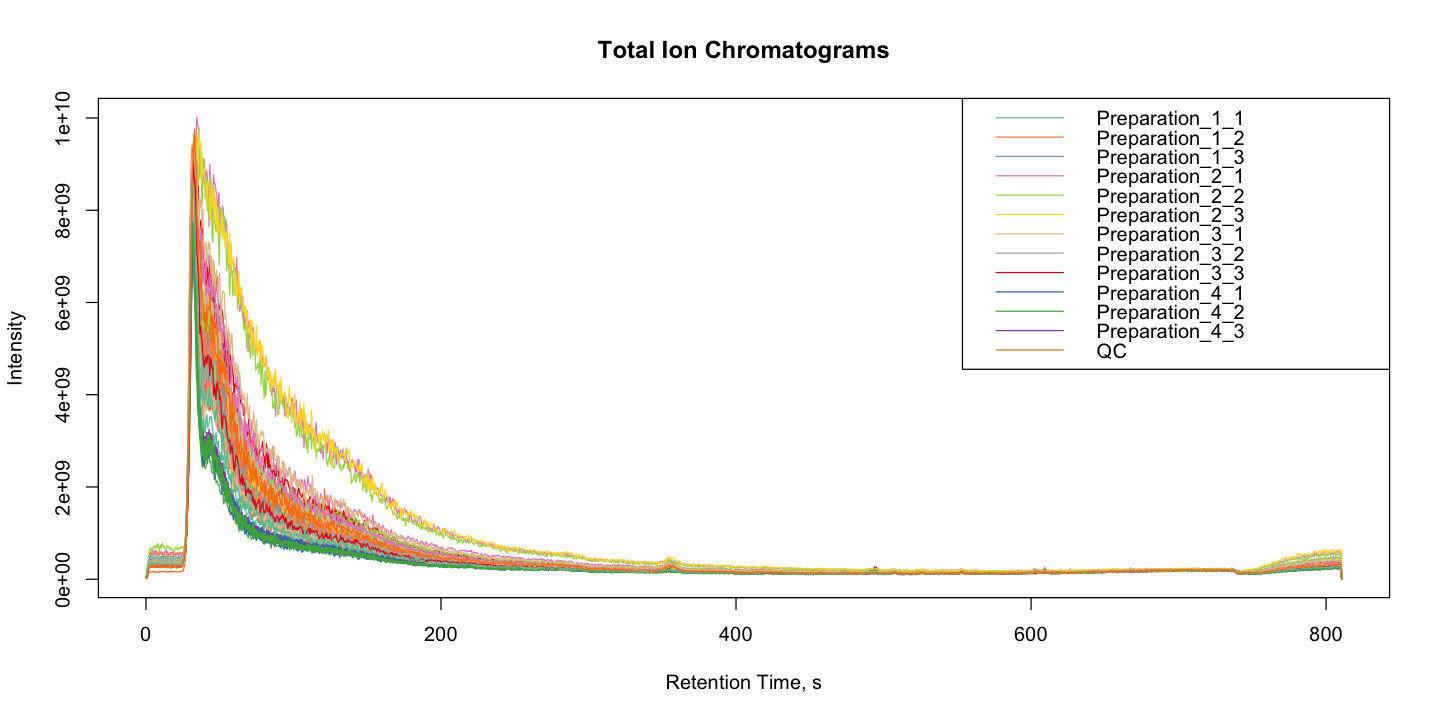

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

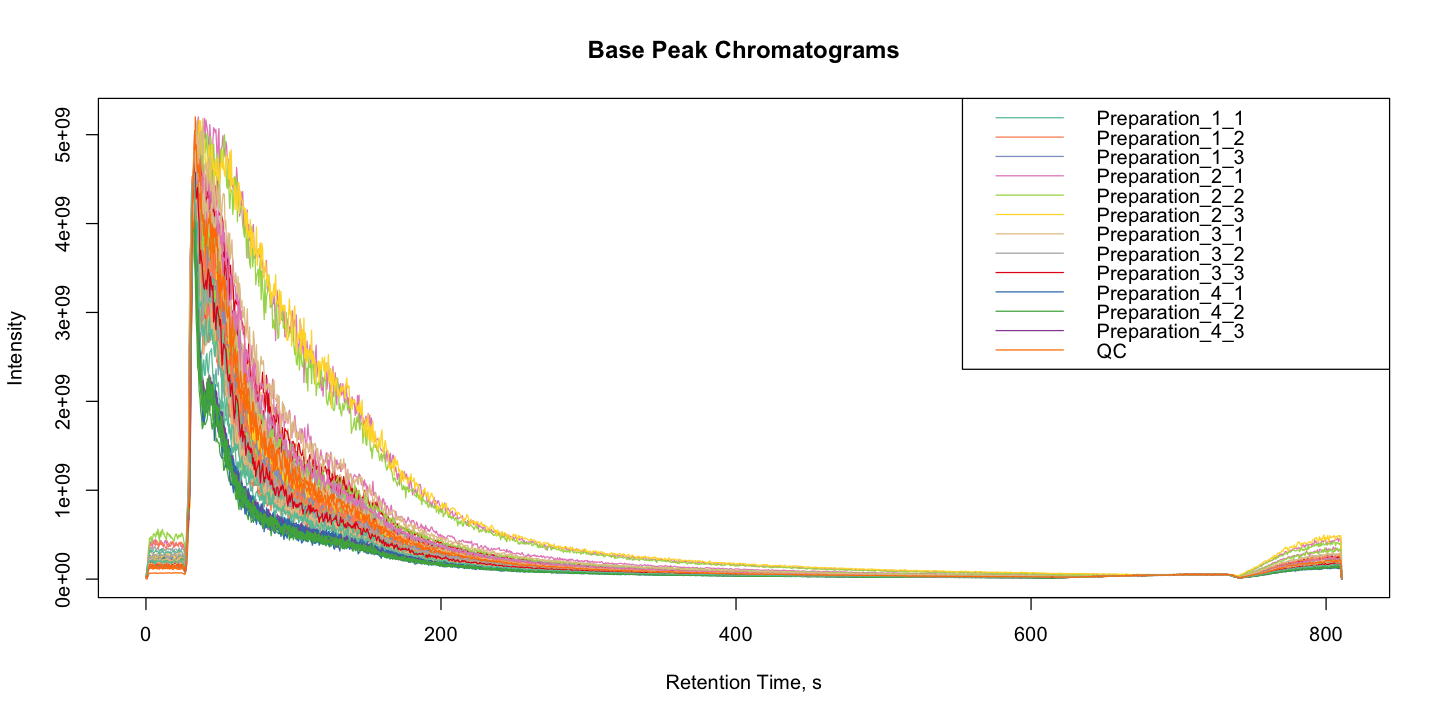

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

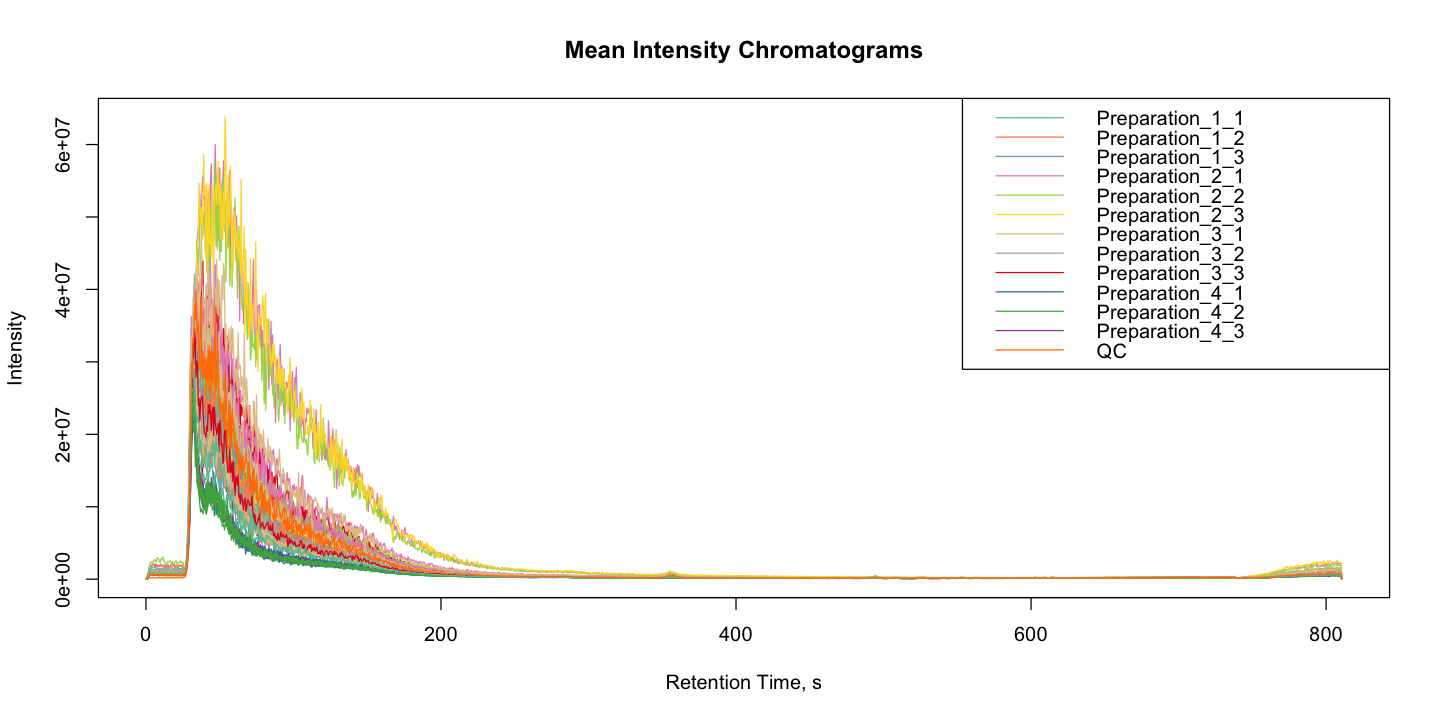

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

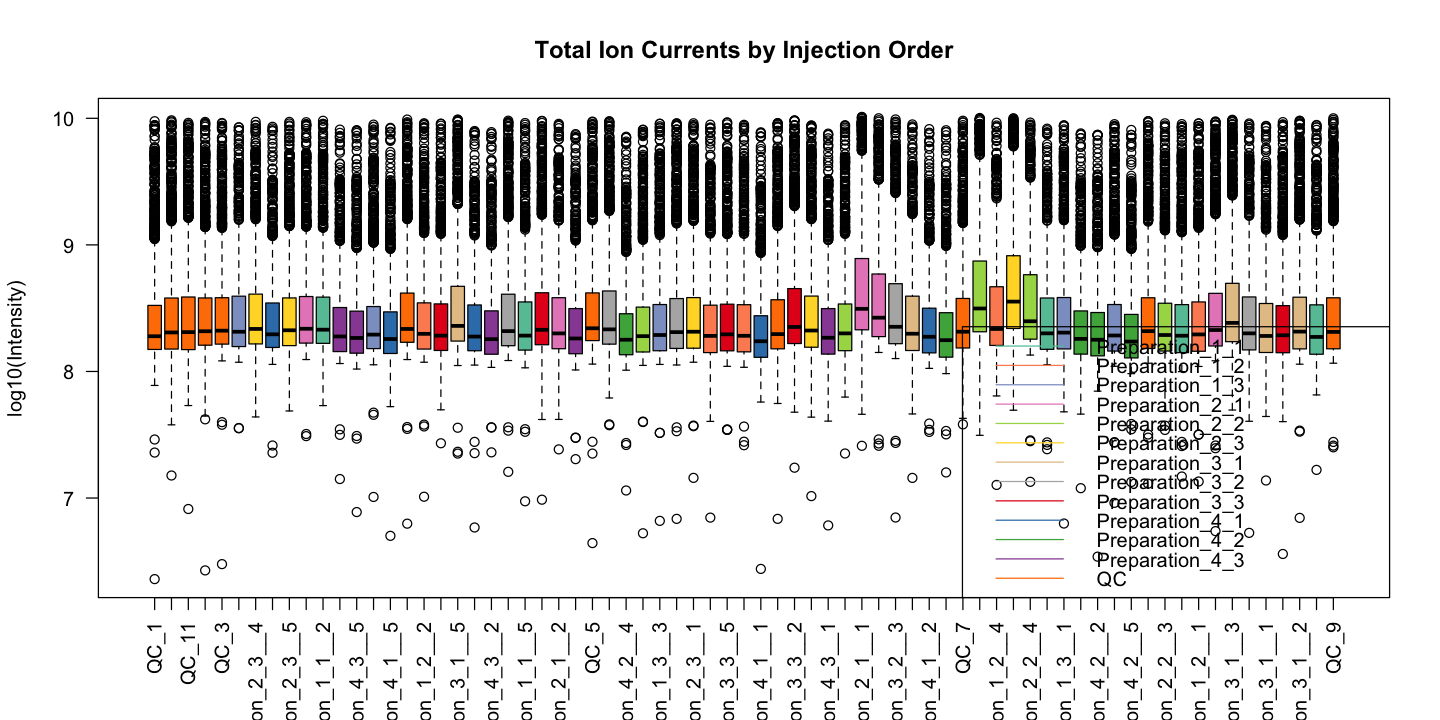

In [9]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

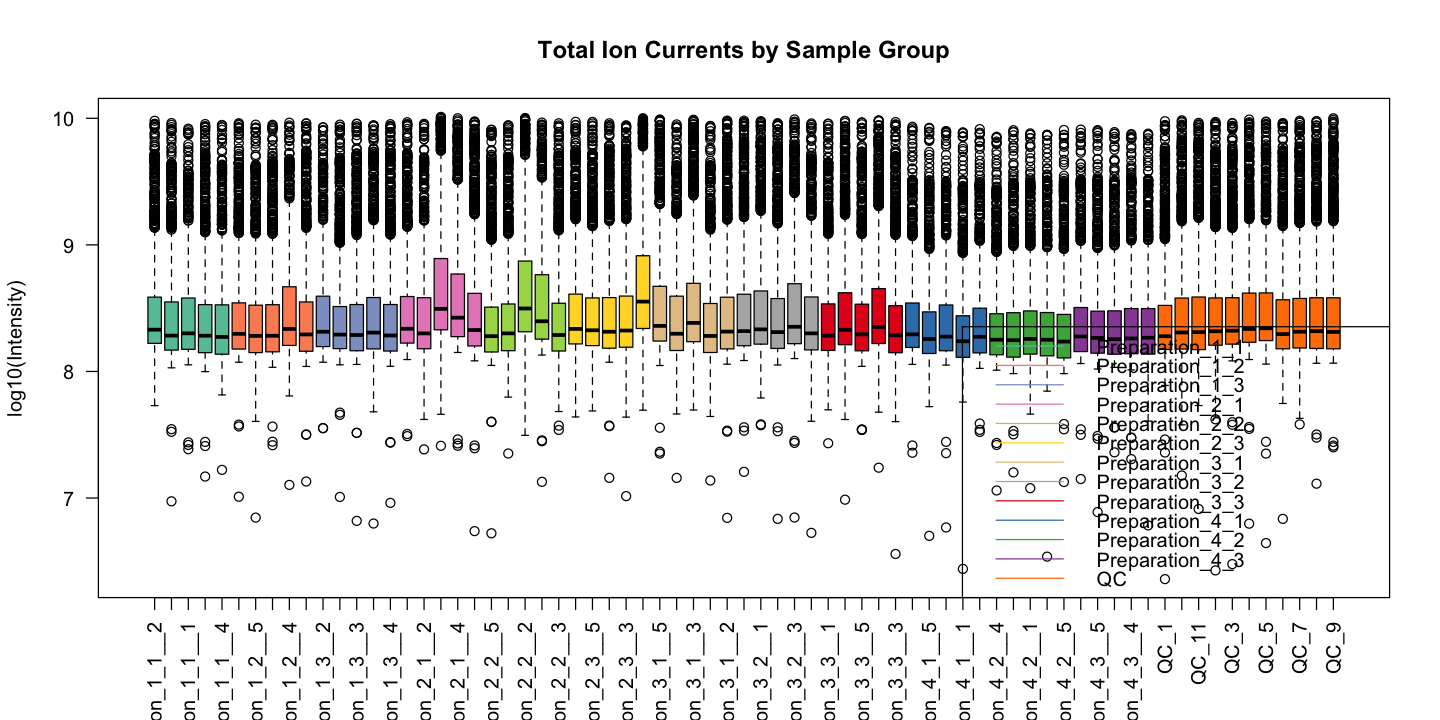

In [10]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(8.9, 19), ppm = 2.3, snthresh = 55, 
                     mzdiff = 0.098,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13], "60")
names(sample.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
sample.colours <- sample.colours[raw$sample_group]

### Retention Time Correction (RT)

In [13]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.4)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

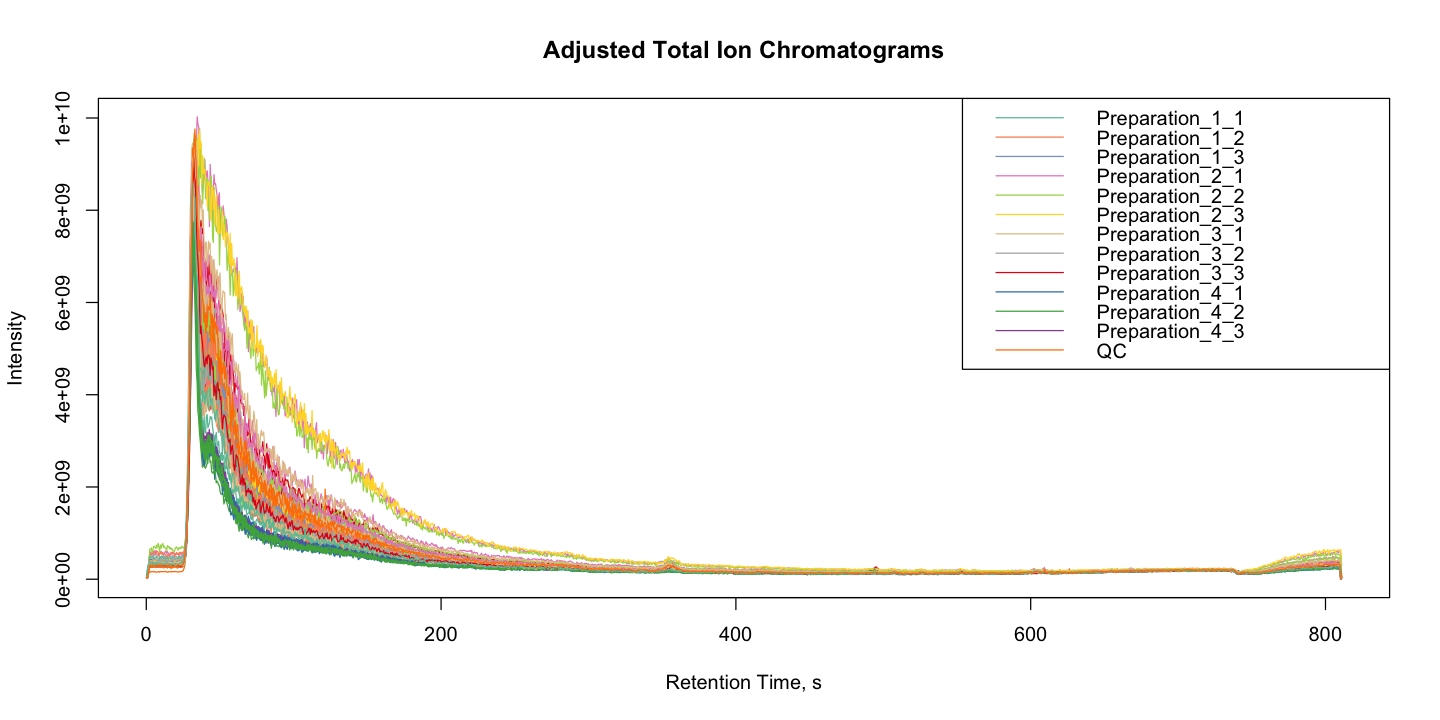

In [14]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

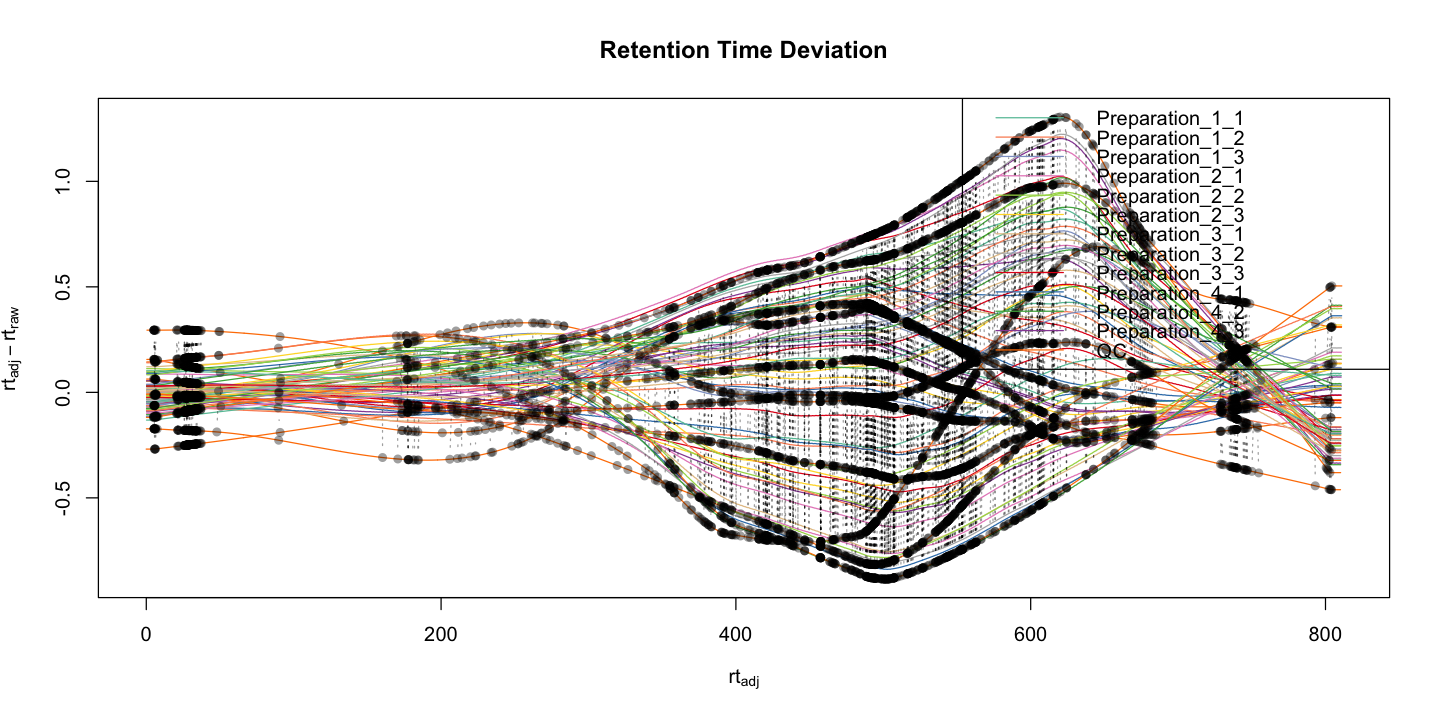

In [15]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [16]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

### Peak Filling

In [17]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [18]:
## Summarise experiment
results <- quantify(set, value = "into")

In [19]:
## Summarise experiment
results <- quantify(set)

In [20]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [21]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 149 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 241 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 149 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 149 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  548 
xsAnnotate has now 548 groups, instead of 149 
Generating peak matrix for peak annotation!

Calculating possible adducts in 548 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [22]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [23]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

## Normalisation to Extraction solvent

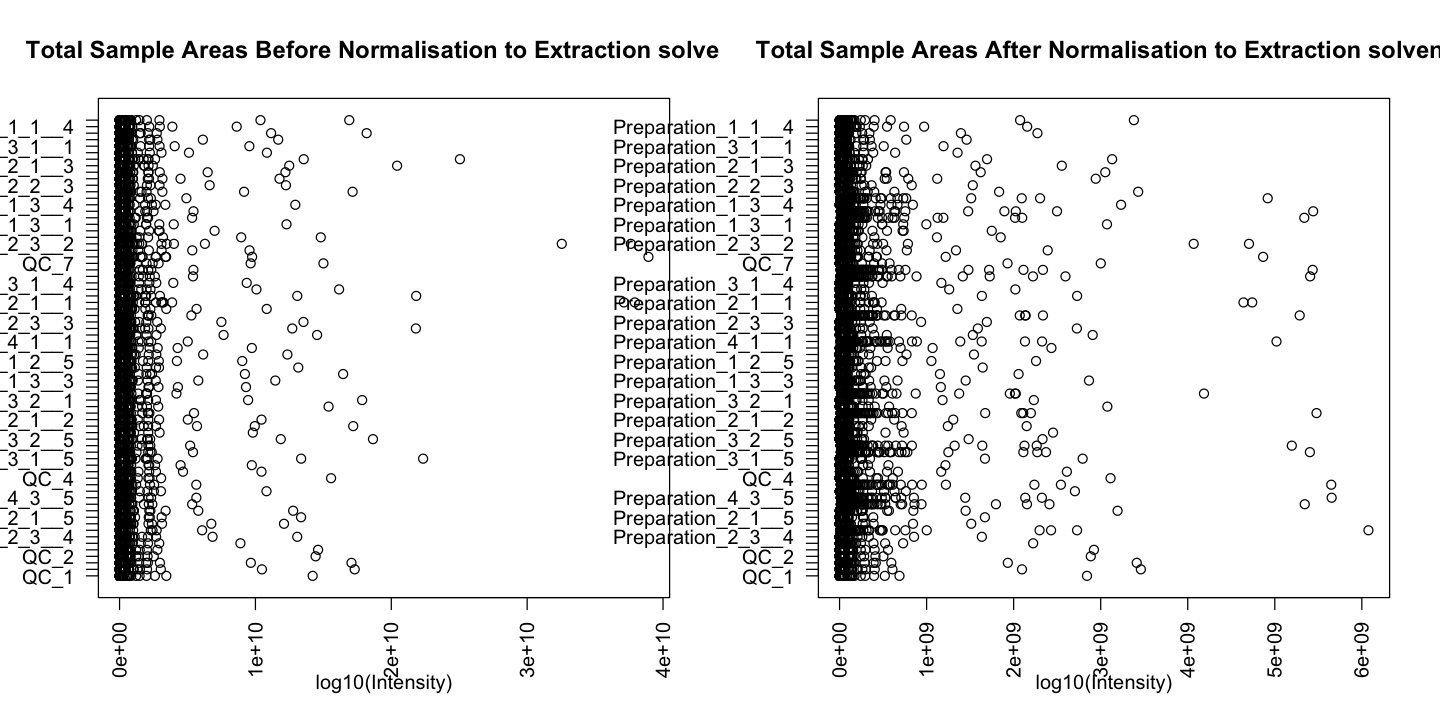

In [24]:
## Normalise data to extraction solvent
norm.weight <- function(x, weight){x / weight}

assay(results, "norm.weight") <- apply(assay(results, "raw"), 1, 
                                       norm.weight, weight = colData(results)$sample_weight) %>%
                                 t()

## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("raw") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation to Extraction solvent", las = 2)

results %>%
assay("norm.weight") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation to Extraction solvent", las = 2)

# IS Area for IS in Extraction Solvents
- Carnitine-d9: [M+H] m/z 171.1690, rt 31 sec 
- Glutamic acid d3:[M+H] m/z 151.0793, rt 29 sec 
- Kynurenic acid d5: [M+H] m/z 195.0813, rt 177 sec 
- Lysin d3: [M+H] m/z 150.1316, rt 26 sec 
- Tryptophan d5: [M+H] m/z 210.1285, rt 172 sec 

Not detected using C18 pos:
- D-Fructose 13C6: m/z (neg:185.0762), rt 30 sec (HILIC 433 sec)
- Hypoxanthine d4:  m/z 141.0709 (neg:139.0563), rt / sec (HILIC / sec)
- Palmitic acid d31: m/z (neg:286.4275), rt 617 sec (HILIC 52 sec)
- Prostaglandin E2 d9: m/z (neg: 360.2742), rt 343 sec (HILIC 182 sec)
- Succinic acid d4: m/z (neg:121.0444), rt 34 sec (HILIC 464 sec)

In [25]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Carnitine-d9 

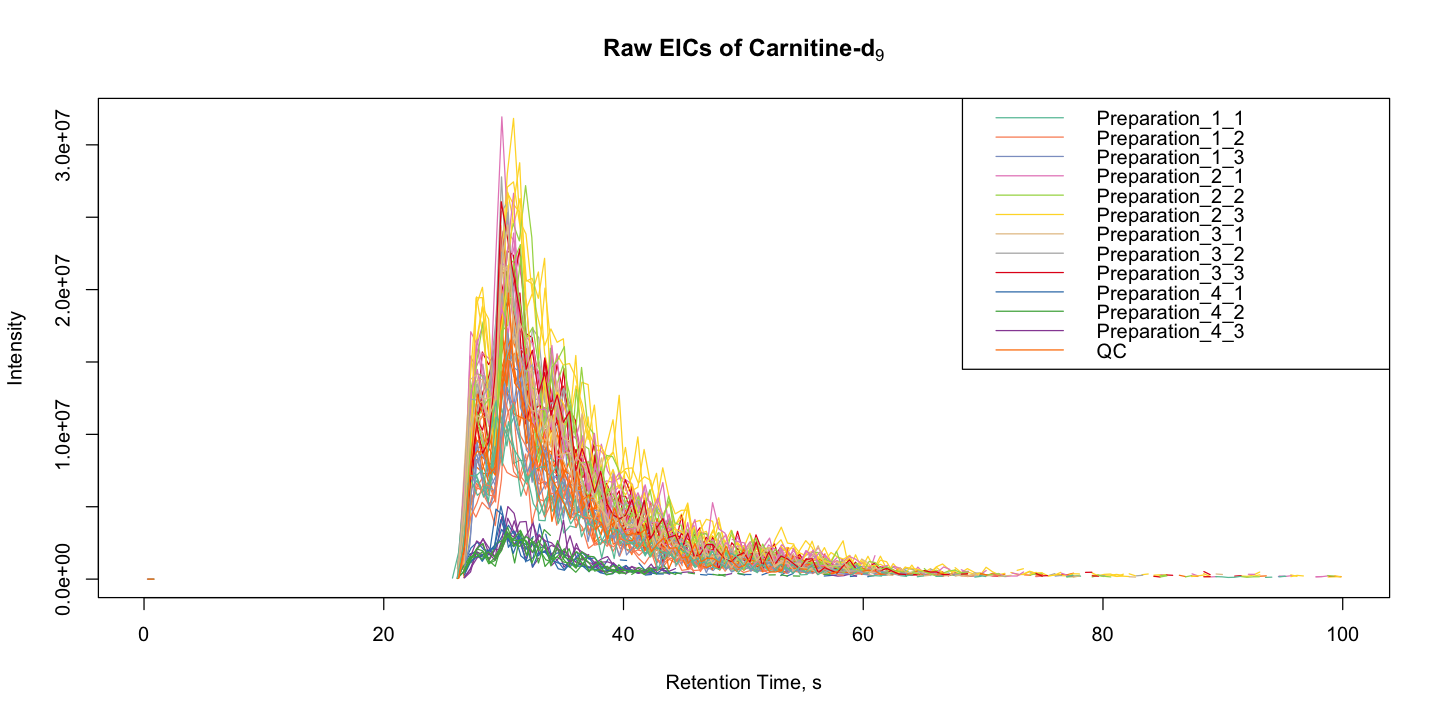

In [26]:
## Plot Carnitine-d9 before processing
card9.raw <- chromatogram(raw, mz = c(171.1680, 171.1700), rt = c(0, 100))

plot(card9.raw, col = group.colours[card9.raw$sample_group], 
     main = bquote(bold("Raw EICs of Carnitine-d"[9])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [27]:
## Identify rownumber of internal standard Carnitine-d9
card9 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 171.1690, rt = 31, 5, 10)
card9 %>% head()

[1] 201

In [28]:
peaklist <- results %>%
assay("norm.weight")
card9 <- peaklist[201,]
area <- data.frame(card9)
preparation <- colData(results)$sample_group
card9 <- cbind(area, preparation)
card9 %>% head()

card9    preparation    
QC_1.mzXML               25320031 QC             
QC_10.mzXML               1154724 QC             
QC_11.mzXML              17633255 QC             
QC_2.mzXML               25223451 QC             
QC_3.mzXML                6204508 QC             
Preparation_1_3__2.mzXML 29036308 Preparation_1_3

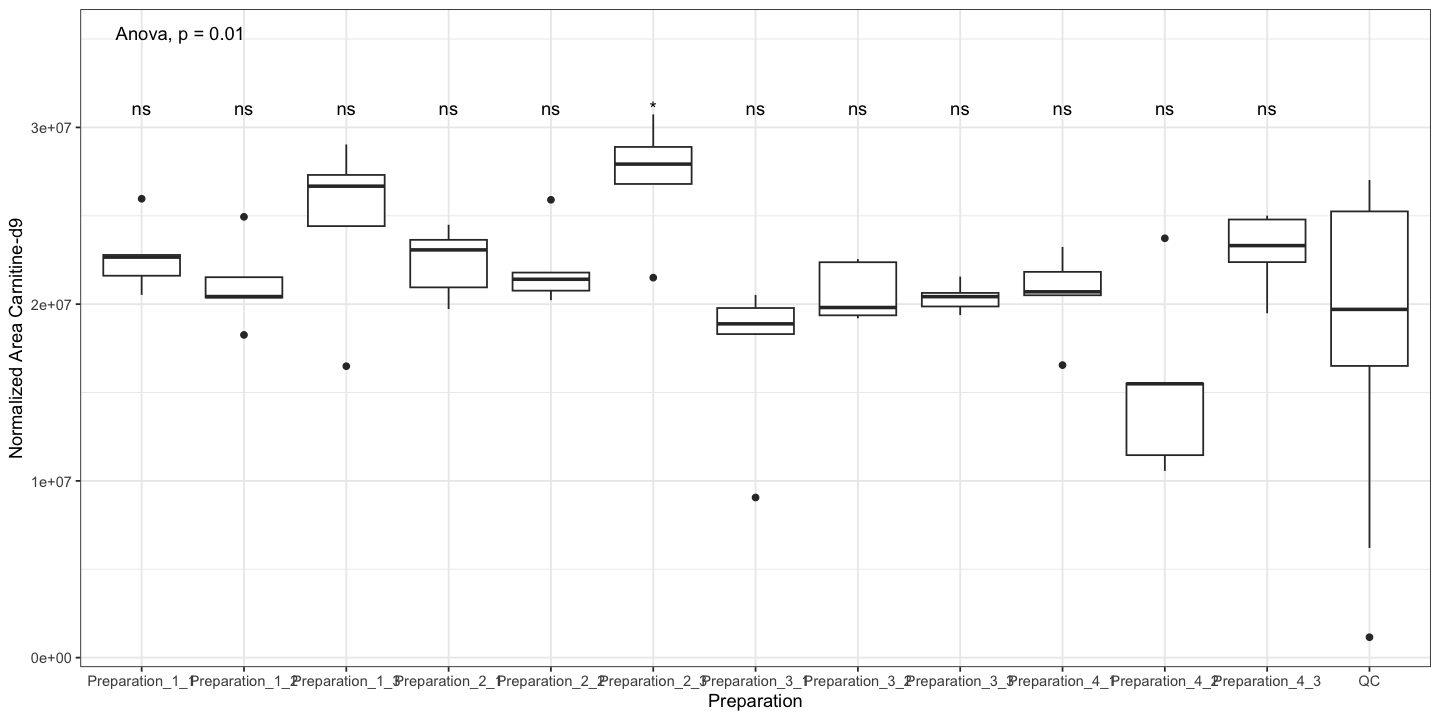

In [29]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(card9, aes(x = factor(preparation), y = card9)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 3.5e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Carnitine-d9") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Glutamic acid d3

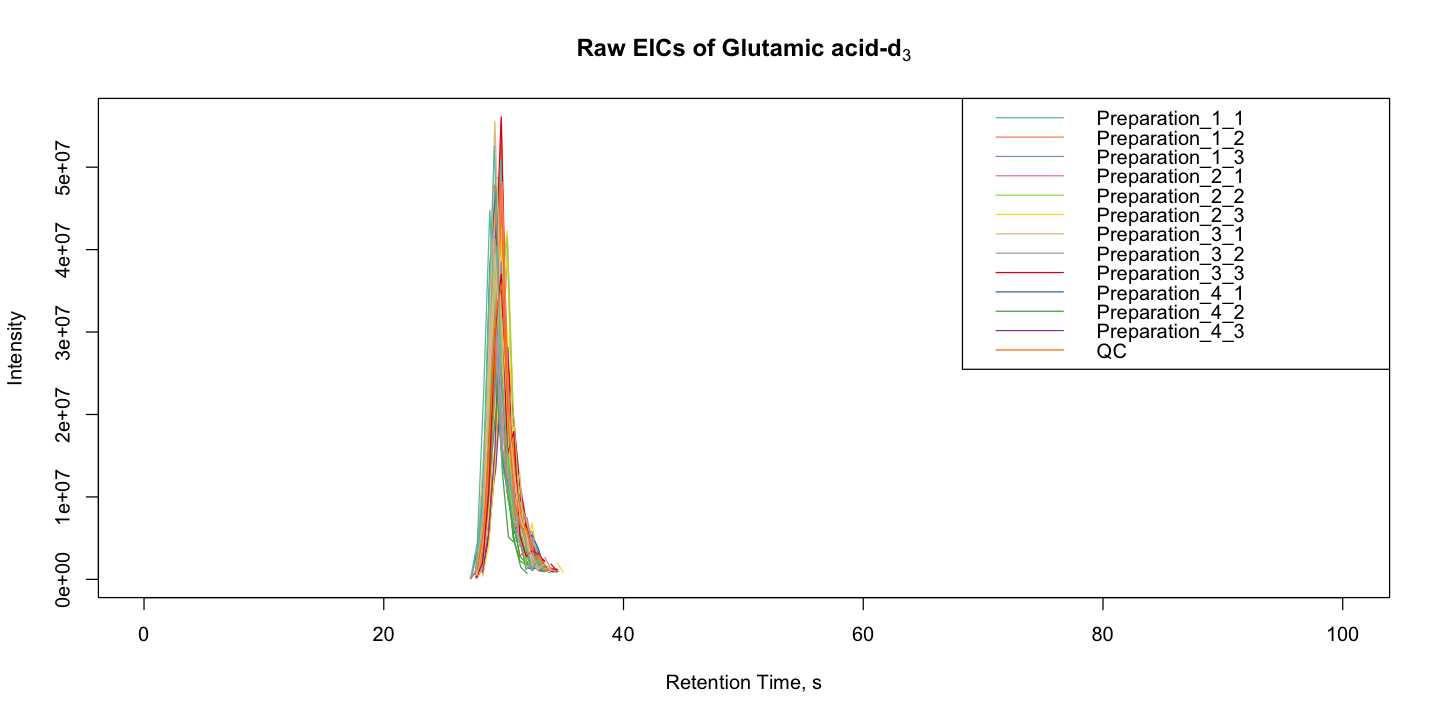

In [30]:
## Plot Carnitine-d9 before processing
glutd3.raw <- chromatogram(raw, mz = c(151.1430, 151.1450), rt = c(0, 100))

plot(glutd3.raw, col = group.colours[glutd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glutamic acid-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [31]:
## Identify rownumber of internal standard Glutamic acid d3
glutd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 151.1441, rt = 29, 5, 10)
glutd3 %>% head()

[1] 162

In [32]:
peaklist <- results %>%
assay("norm.weight")
glutd3 <- peaklist[162,]
area <- data.frame(glutd3)
preparation <- colData(results)$sample_group
glutd3 <- cbind(area, preparation)
glutd3 %>% head()

glutd3   preparation    
QC_1.mzXML               13679725 QC             
QC_10.mzXML              14418819 QC             
QC_11.mzXML              14033674 QC             
QC_2.mzXML               14986649 QC             
QC_3.mzXML               13402240 QC             
Preparation_1_3__2.mzXML 15181504 Preparation_1_3

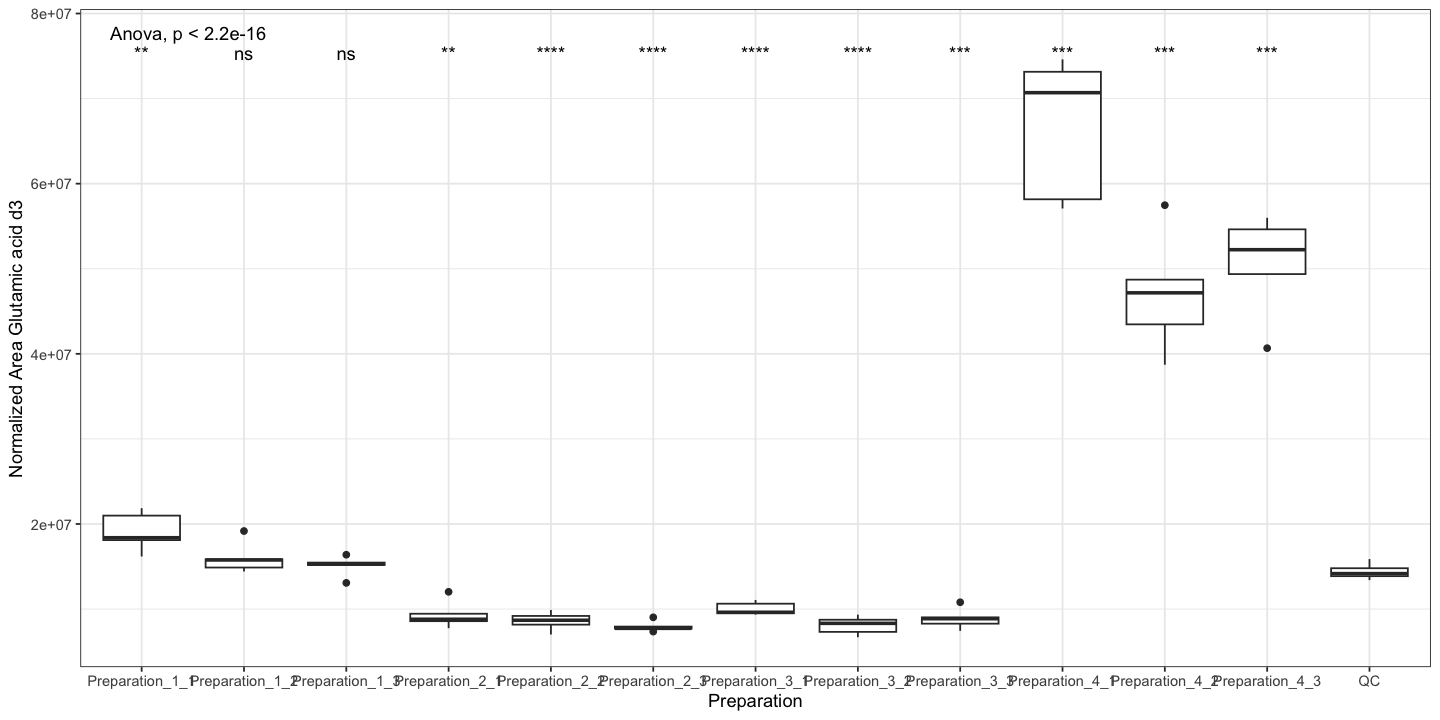

In [33]:
## Plot Area of IS of all extractions
ggplot(glutd3, aes(x = factor(preparation), y = glutd3)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 7.7e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Glutamic acid d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

###  Kynurenic acid d5

In [34]:
## Identify rownumber of internal standard Kynurenic acid d5 
kynd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 195.0813, rt = 177, 5, 10)
kynd5 %>% head()

[1] 260

In [35]:
peaklist <- results %>%
assay("norm.weight")
kynd5 <- peaklist[260,]
area <- data.frame(kynd5)
preparation <- colData(results)$sample_group
kynd5 <- cbind(area, preparation)
kynd5 %>% head()

kynd5     preparation    
QC_1.mzXML               463095.19 QC             
QC_10.mzXML              166565.22 QC             
QC_11.mzXML              310323.34 QC             
QC_2.mzXML                70982.19 QC             
QC_3.mzXML               557139.94 QC             
Preparation_1_3__2.mzXML 429952.71 Preparation_1_3

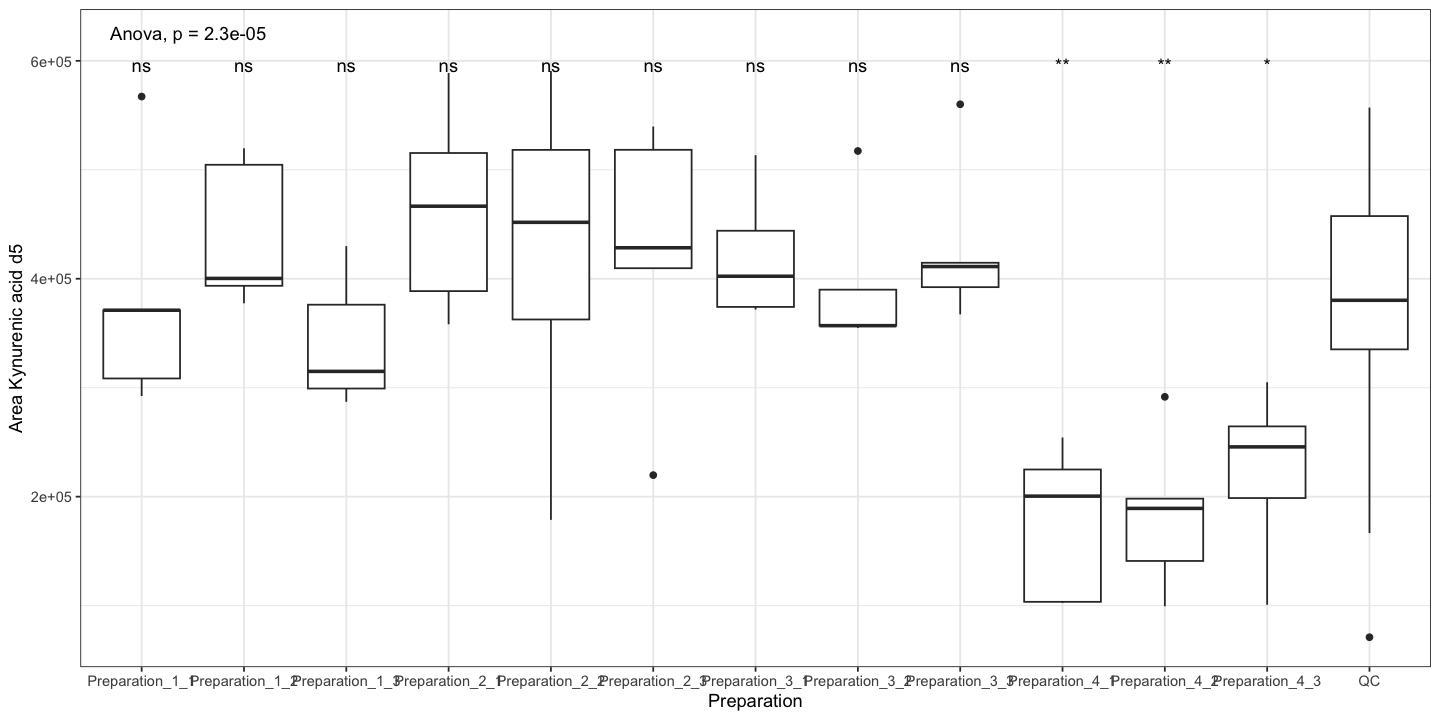

In [36]:
## Plot Area of IS of all extractions
ggplot(kynd5, aes(x = factor(preparation), y = kynd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 6.2e+05)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Kynurenic acid d5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Lysin d3

In [37]:
## Identify rownumber of internal standard Lysin d3
lysd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 150.1316, rt = 26, 5, 10)
lysd3 %>% head()

[1] 156

In [38]:
peaklist <- results %>%
assay("norm.weight")
lysd3 <- peaklist[156,]
area <- data.frame(lysd3)
preparation <- colData(results)$sample_group
lysd3 <- cbind(area, preparation)
lysd3 %>% head()

lysd3    preparation    
QC_1.mzXML               242668.4 QC             
QC_10.mzXML              220407.8 QC             
QC_11.mzXML              224022.7 QC             
QC_2.mzXML               314953.8 QC             
QC_3.mzXML               120660.0 QC             
Preparation_1_3__2.mzXML 594470.7 Preparation_1_3

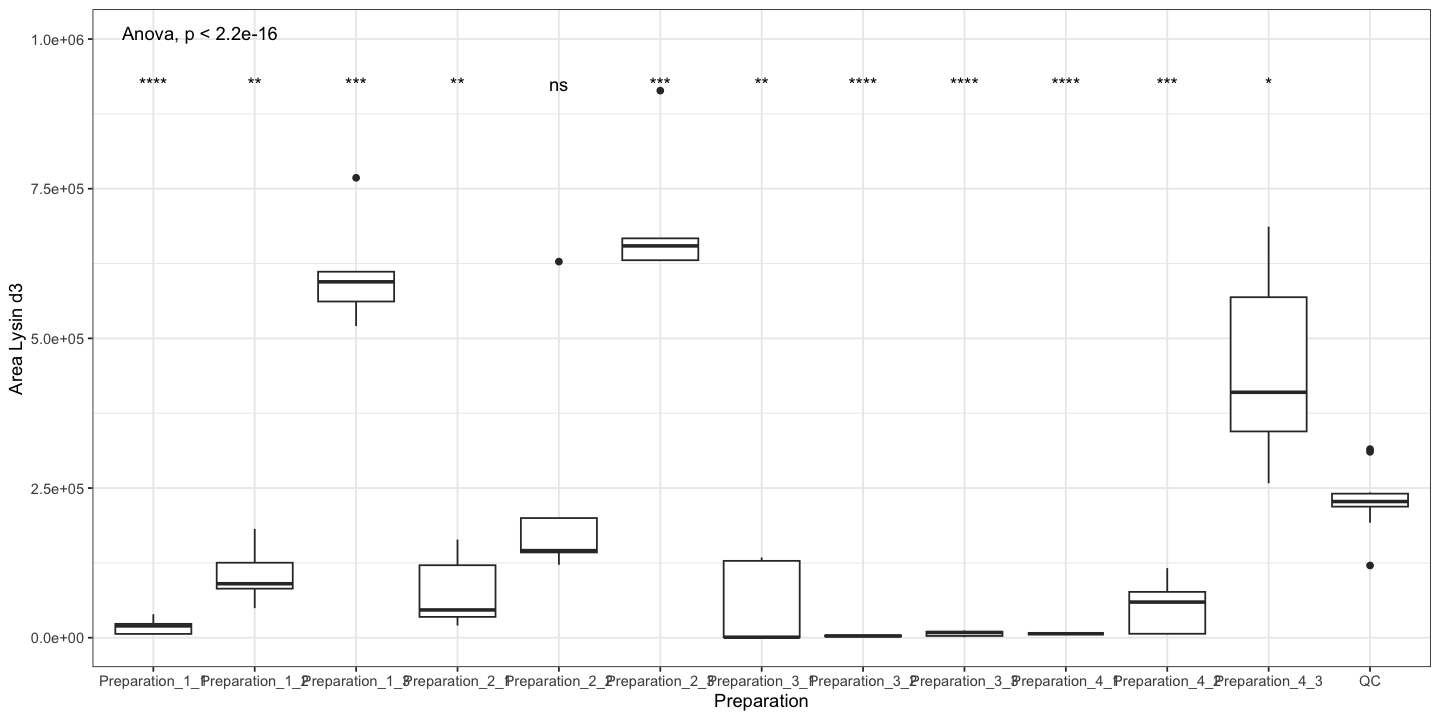

In [39]:
## Plot Area of IS of all extractions
ggplot(lysd3, aes(x = factor(preparation), y = lysd3)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Lysin d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Hypoxanthin d4

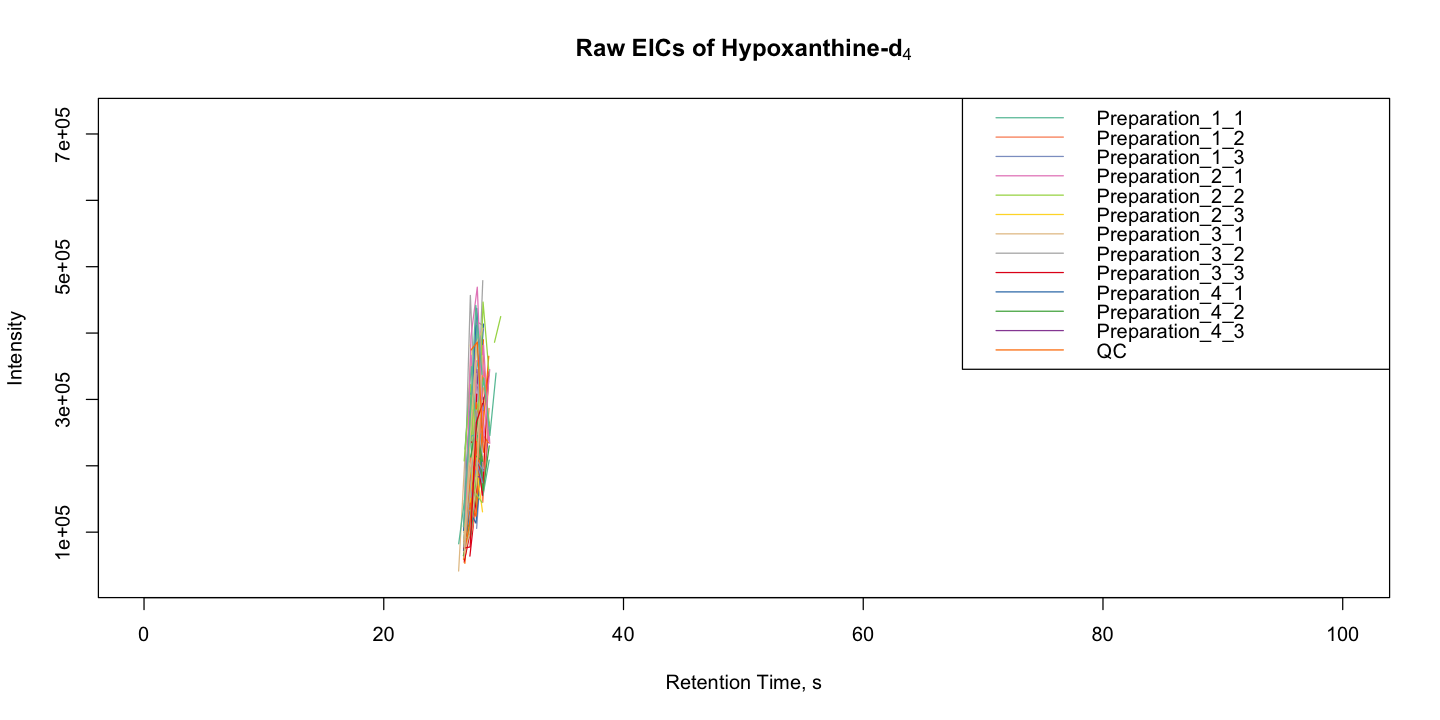

In [40]:
## Plot Carnitine-d9 before processing
hypd4.raw <- chromatogram(raw, mz = c(141.0690, 141.0720), rt = c(0, 100))

plot(hypd4.raw, col = group.colours[hypd4.raw$sample_group], 
     main = bquote(bold("Raw EICs of Hypoxanthine-d"[4])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [41]:
## Identify rownumber of internal standard Kynurenic acid d5 
hypd4 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 141.0709, rt = 25, 5, 10)
hypd4 %>% head()

integer(0)

### Trp-d5

In [42]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 210.1291, rt = 177, 5, 10)
trpd5 %>% head()

[1] 293

In [43]:
peaklist <- results %>%
assay("norm.weight")
trpd5 <- peaklist[293,]
area <- data.frame(trpd5)
preparation <- colData(results)$sample_group
trpd5 <- cbind(area, preparation)
trpd5 %>% head()

trpd5   preparation    
QC_1.mzXML               3170151 QC             
QC_10.mzXML              2613956 QC             
QC_11.mzXML              2731906 QC             
QC_2.mzXML               3290868 QC             
QC_3.mzXML               3725939 QC             
Preparation_1_3__2.mzXML 2978317 Preparation_1_3

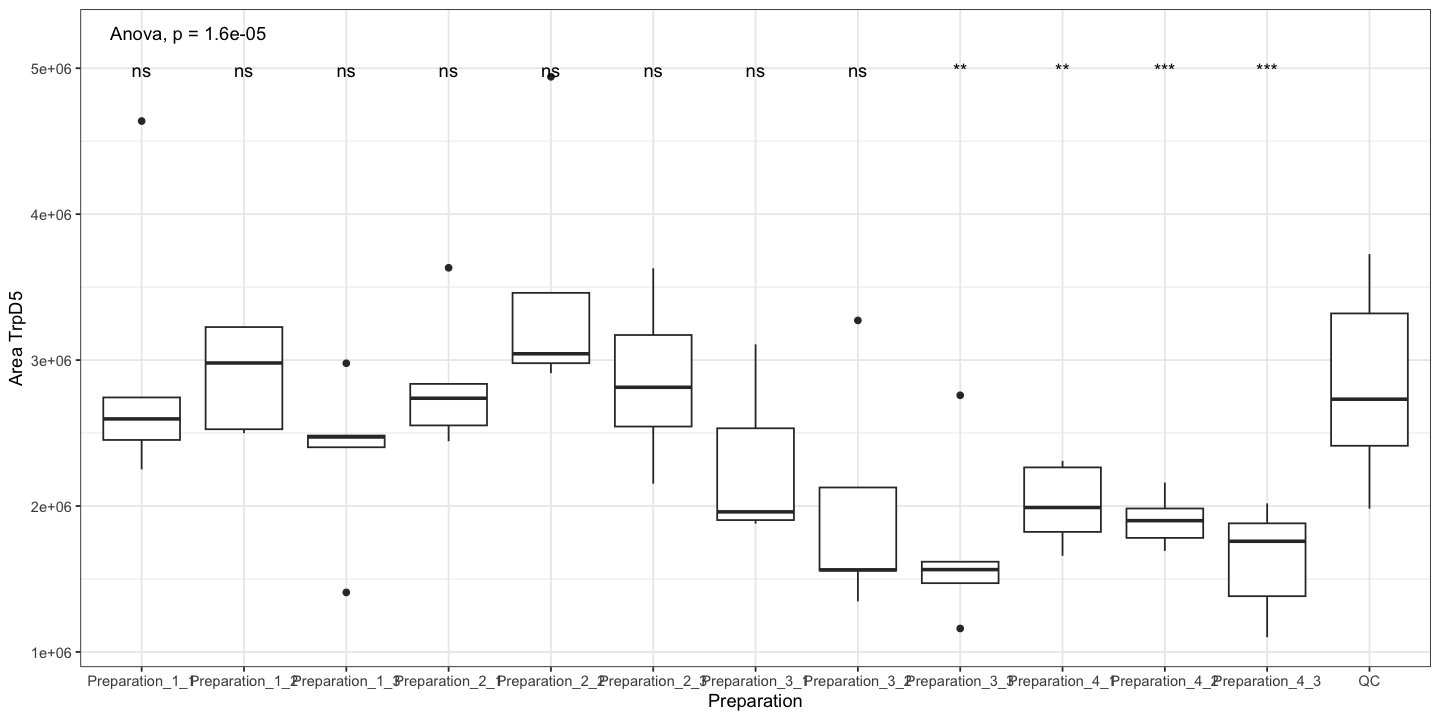

In [44]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(trpd5, aes(x = factor(preparation), y = trpd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 5.2e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area TrpD5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

## IS Area for IS in Reconstitution Solvent 

Positive:
- n.d.: Arginine d7: m/z 182.1629, rt 28 sec (HILIC 500 sec)
- n.d.: Aspartic acid d3: m/z 137.0636, rt 28 sec (HILIC 498 sec)
- n.d.: Creatinine d3: m/z 117.0850, rt 30 sec (HILIC 285 sec)
- Cytosine d2: m/z 114.0631, rt 30 sec (HILIC 329 sec)
- n.d.: Glycin N15: m/z 77.0363 (neg:75.0218), rt / sec (HILIC / sec)
- n.d.: Thymidine d4: m/z 247.1227, rt 0 sec (HILIC 198 sec)

Negative:
- Arginine d7: m/z 180.1483, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 135.0491, rt 28 sec (HILIC 498 sec)
- Cortisol d4: m/z 365.2271, rt 598 sec (HILIC / sec)
- Glucose d7: m/z 186.1000, rt 29 sec (HILIC 456 sec)
- Stearic acid 13C: m/z 284.2676, rt / sec (HILIC 69 sec)
- Thymidine d4: m/z 245.1081, rt 0 sec (HILIC 198 sec)

### Crea

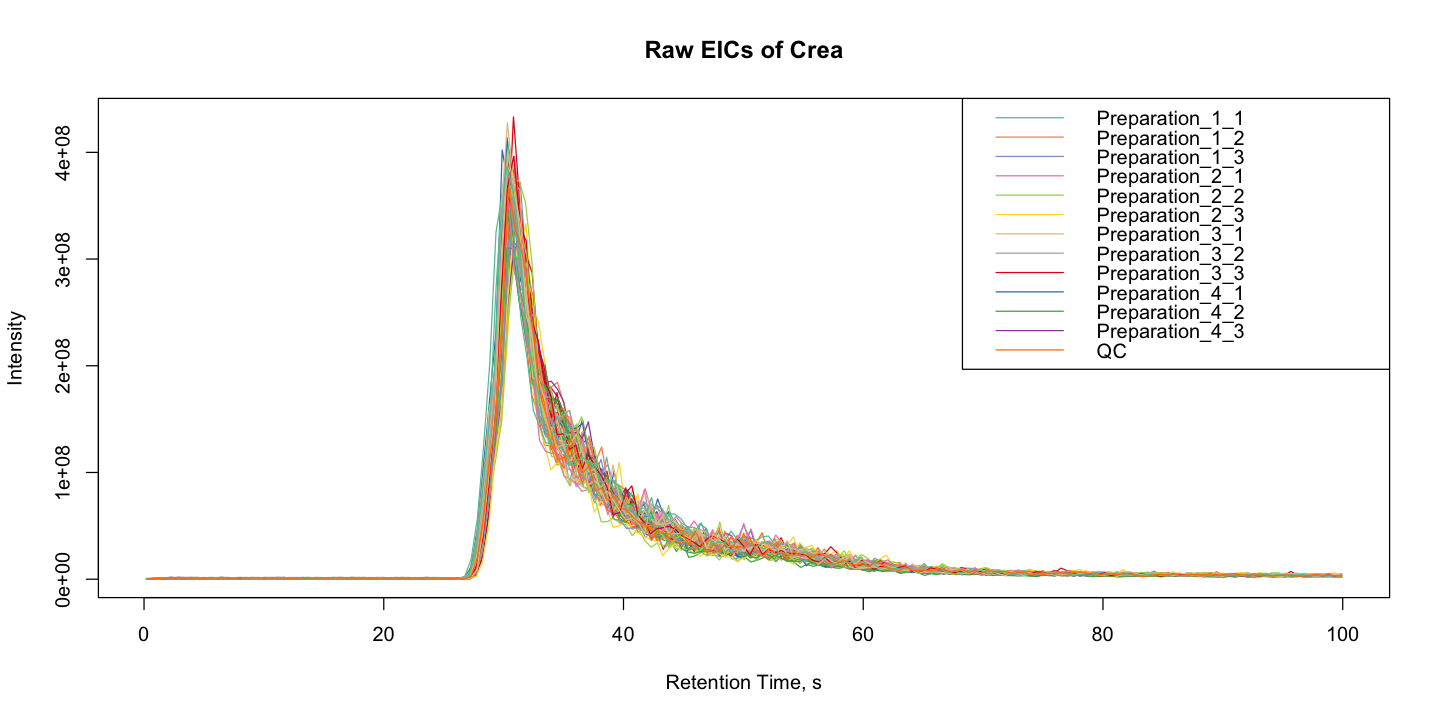

In [45]:
## Plot Carnitine-d9 before processing
crea.raw <- chromatogram(raw, mz = c(114.0650, 114.0680), rt = c(0, 100))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Crea")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [46]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0665, rt = 30, 5, 10)
crea %>% head()

[1] 72

In [47]:
peaklist <- results %>%
assay("raw")
crea <- peaklist[72,]
area <- data.frame(crea)
preparation <- colData(results)$sample_group
crea <- cbind(area, preparation)
crea %>% head()

crea       preparation    
QC_1.mzXML               1979821625 QC             
QC_10.mzXML              2020802700 QC             
QC_11.mzXML              1957868471 QC             
QC_2.mzXML               2063822310 QC             
QC_3.mzXML               2014501171 QC             
Preparation_1_3__2.mzXML 2094486108 Preparation_1_3

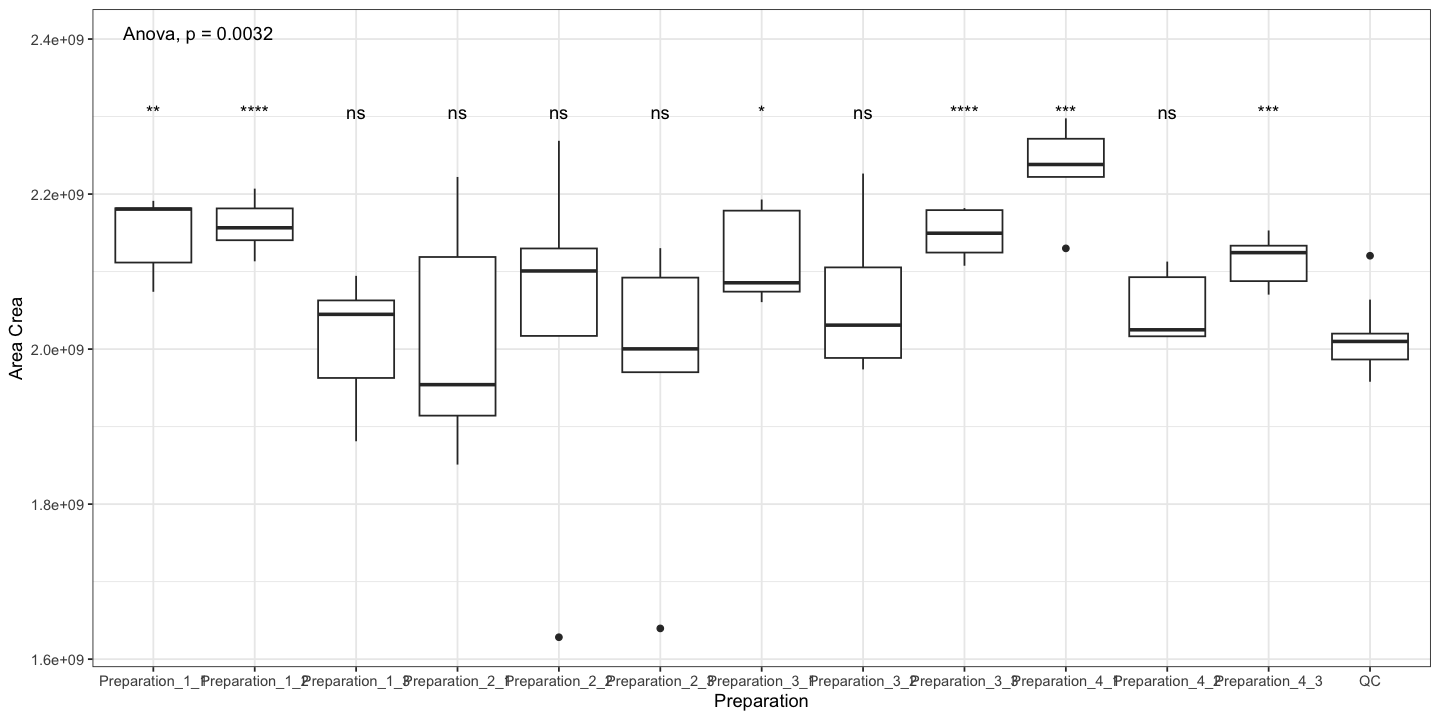

In [48]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(crea, aes(x = factor(preparation), y = crea)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 2.4e+09)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area Crea") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

In [49]:
write_xlsx(list(glutd3 = as.data.frame(glutd3), 
                trpd5 = as.data.frame(trpd5),
                kynd5 = as.data.frame(kynd5),
                lysd3 = as.data.frame(lysd3),
                card9 = as.data.frame(card9),
                crea = as.data.frame(crea)), 
           "Rat_Urine_Extraction_C18_pos_IS.xlsx")

## Feature Summary for all IS

In [50]:
Summaryfeature <- featureSummary(set, set$sample_group , perSampleCounts = TRUE, method = "maxint", skipFilled = TRUE)
Summaryfeature %>% head()

count perc      multi_count multi_perc rsd       QC_count QC_perc  
FT0001 36     50.70423 0           0          0.1711323  6        54.54545
FT0002  9     12.67606 0           0          0.7255328  2        18.18182
FT0003 60     84.50704 0           0          0.3073412 11       100.00000
FT0004 23     32.39437 0           0          0.2182911  0         0.00000
FT0005 71    100.00000 0           0          0.1522027 11       100.00000
FT0006 56     78.87324 0           0          0.2583694  9        81.81818
       QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT0001 0              0             0.09742242 ⋯ 1                       
FT0002 0              0             0.05709891 ⋯ 0                       
FT0003 0              0             0.22729513 ⋯ 1                       
FT0004 0              0                     NA ⋯ 1                       
FT0005 0              0             0.15150702 ⋯ 1                       
FT0006 0              0             0.06571707 ⋯ 1                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0001 0                        1                       
FT0002 0                        0                       
FT0003 0                        1                       
FT0004 0                        0                       
FT0005 1                        1                       
FT0006 1                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0001 0                        1                       
FT0002 0                        0                       
FT0003 0                        1                       
FT0004 0                        1                       
FT0005 1                        1                       
FT0006 0                        1                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0001 1                        0                       
FT0002 0                        0                       
FT0003 1                        1                       
FT0004 1                        0                       
FT0005 1                        1                       
FT0006 1                        1                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_9.mzXML
FT0001 0                        1                        0         
FT0002 0                        0                        0         
FT0003 1                        1                        1         
FT0004 0                        0                        0         
FT0005 1                        1                        1         
FT0006 0                        1                        1

In [51]:
write_xlsx(as.data.frame(Summaryfeature), "Summaryfeature.xlsx")

In [52]:
peakdata <- as.data.frame(rowData(results))
IS <- Summaryfeature[c(72,156,162,201,260,293),]
#IS.peakdata <- peakdata[c(72,156,162,201,260,293),]
#SumFeat <- cbind(IS.peakdata, c(IS))
IS %>% head()

count perc      multi_count multi_perc rsd        QC_count QC_perc  
FT0072 71    100.00000 0           0.000000   0.05818921 11       100.00000
FT0156 26     36.61972 1           3.846154   0.81834095  8        72.72727
FT0162 71    100.00000 0           0.000000   0.16993502 11       100.00000
FT0201 36     50.70423 0           0.000000   0.30712248  5        45.45455
FT0260 17     23.94366 0           0.000000   0.29220418  3        27.27273
FT0293 71    100.00000 0           0.000000   0.62992855 11       100.00000
       QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT0072 0               0.0          0.02232332 ⋯ 1                       
FT0156 1              12.5          0.18217667 ⋯ 0                       
FT0162 0               0.0          0.05111237 ⋯ 1                       
FT0201 0               0.0          0.05940330 ⋯ 1                       
FT0260 0               0.0          0.18962387 ⋯ 0                       
FT0293 0               0.0          0.20614924 ⋯ 1                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0072 1                        1                       
FT0156 1                        0                       
FT0162 1                        1                       
FT0201 0                        0                       
FT0260 0                        0                       
FT0293 1                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0072 1                        1                       
FT0156 0                        0                       
FT0162 1                        1                       
FT0201 0                        1                       
FT0260 1                        1                       
FT0293 1                        1                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0072 1                        1                       
FT0156 0                        0                       
FT0162 1                        1                       
FT0201 1                        1                       
FT0260 0                        0                       
FT0293 1                        1                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_9.mzXML
FT0072 1                        1                        1         
FT0156 1                        0                        1         
FT0162 1                        1                        1         
FT0201 1                        1                        0         
FT0260 1                        0                        0         
FT0293 1                        1                        1

In [53]:
write_xlsx(as.data.frame(IS), "Summaryfeature.IS.xlsx")

## Export data set for additional evaluations

In [71]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_C18_pos_count.xlsx")

## Save dataset

In [72]:
save.image("Rat_Urine_Extraction_C18_pos_sig.RData")

In [73]:
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [74]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

# Feature Count

In [75]:
peaklist <- results %>%
assay("raw")
peaklist <- as.data.frame(t(peaklist))
peaklist %>% head()

FT0001  FT0002   FT0003    FT0004    FT0005   
QC_1.mzXML                    NA 72948719 168606478        NA 255584630
QC_10.mzXML              3148864  1266017 205236282   6077627 270577719
QC_11.mzXML              2302036  1186589 270265263 144165347 267751995
QC_2.mzXML               2559551 80579589 186546543        NA 203629118
QC_3.mzXML               2849887 77246369 179789062        NA 275337297
Preparation_1_3__2.mzXML 2205672 87509772 156502784        NA 212386155
                         FT0006    FT0007    FT0008    FT0009    FT0010    ⋯
QC_1.mzXML                 9003184 213533350 122192535        NA 1012148.8 ⋯
QC_10.mzXML              130130932 206781727        NA  69871308  678215.9 ⋯
QC_11.mzXML              118686558 188850960 101040722 158815632  582664.6 ⋯
QC_2.mzXML               124548231 216538863        NA        NA  836869.6 ⋯
QC_3.mzXML               105833701 214683954  19554693 106778258  314306.5 ⋯
Preparation_1_3__2.mzXML  79832645        NA 115753148  38914284 1543012.6 ⋯
                         FT1217  FT1218    FT1219    FT1220  FT1221   FT1222  
QC_1.mzXML               7471888 6051731.8 2885514.3 3367268 678985.9 190210.3
QC_10.mzXML              1927600 3360504.5 1462441.3 1380932 179308.9 292867.5
QC_11.mzXML              2769267 2751721.2 1192208.4 1202016 142079.0 201298.8
QC_2.mzXML               7569000 3649309.3 2912314.7 3258397 691416.9 328999.2
QC_3.mzXML               7821738  577779.7  888089.4 3232665 538216.6 188080.0
Preparation_1_3__2.mzXML 7711689 6674953.2 3000034.6 3388842 609884.1 318437.5
                         FT1223    FT1224   FT1225   FT1226   
QC_1.mzXML                845595.1 452341.2 184285.1 101330.10
QC_10.mzXML              1261176.6 225819.0 633335.5 144289.75
QC_11.mzXML               931892.8 311691.6 544828.4  55293.31
QC_2.mzXML                848668.0 515115.7 287240.9  29800.25
QC_3.mzXML                493188.4 353016.4 126299.7  57270.93
Preparation_1_3__2.mzXML  735223.1 384312.7 172605.4  37022.00

In [76]:
## Plot feature count (peaknumber)
peaklist[peaklist == 0] <- NA
peaklist[is.na(peaklist) == FALSE] <- 1
peaklist[is.na(peaklist) == TRUE] <- 0
#peaklist$Sum <- apply(peaklist, 1, sum)
count <- apply(peaklist, 1, sum)
count <- as.data.frame(count)
preparation <- colData(results)$sample_group
preparation <- as.data.frame(preparation)
peaklist <- cbind(peaklist, c(count), c(preparation))

peaknumber_order <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
peaklist <- peaklist[!(row.names(peaklist) %in% c("QC_1.mzXML","QC_2.mzXML","QC_3.mzXML","QC_4.mzXML","QC_5.mzXML",
                                                 "QC_6.mzXML","QC_7.mzXML","QC_8.mzXML","QC_9.mzXML","QC_10.mzXML","QC_11.mzXML")),]
peaklist %>% head()
#count %>% head()

FT0001 FT0002 FT0003 FT0004 FT0005 FT0006 FT0007
Preparation_1_3__2.mzXML 1      1      1      0      1      1      0     
Preparation_2_3__4.mzXML 1      1      1      0      1      1      1     
Preparation_4_1__3.mzXML 1      1      1      1      1      1      0     
Preparation_2_3__5.mzXML 1      1      1      0      1      1      0     
Preparation_2_1__5.mzXML 1      1      1      0      1      1      1     
Preparation_1_1__2.mzXML 1      1      1      1      1      1      1     
                         FT0008 FT0009 FT0010 ⋯ FT1219 FT1220 FT1221 FT1222
Preparation_1_3__2.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_3__4.mzXML 0      1      1      ⋯ 1      1      1      1     
Preparation_4_1__3.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_3__5.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_1__5.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_1_1__2.mzXML 1      1      1      ⋯ 1      1      1      1     
                         FT1223 FT1224 FT1225 FT1226 count preparation    
Preparation_1_3__2.mzXML 1      1      1      1      1180  Preparation_1_3
Preparation_2_3__4.mzXML 1      1      1      1      1182  Preparation_2_3
Preparation_4_1__3.mzXML 1      1      1      1      1138  Preparation_4_1
Preparation_2_3__5.mzXML 1      1      1      1      1189  Preparation_2_3
Preparation_2_1__5.mzXML 1      1      1      1      1179  Preparation_2_1
Preparation_1_1__2.mzXML 1      1      1      1      1175  Preparation_1_1

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


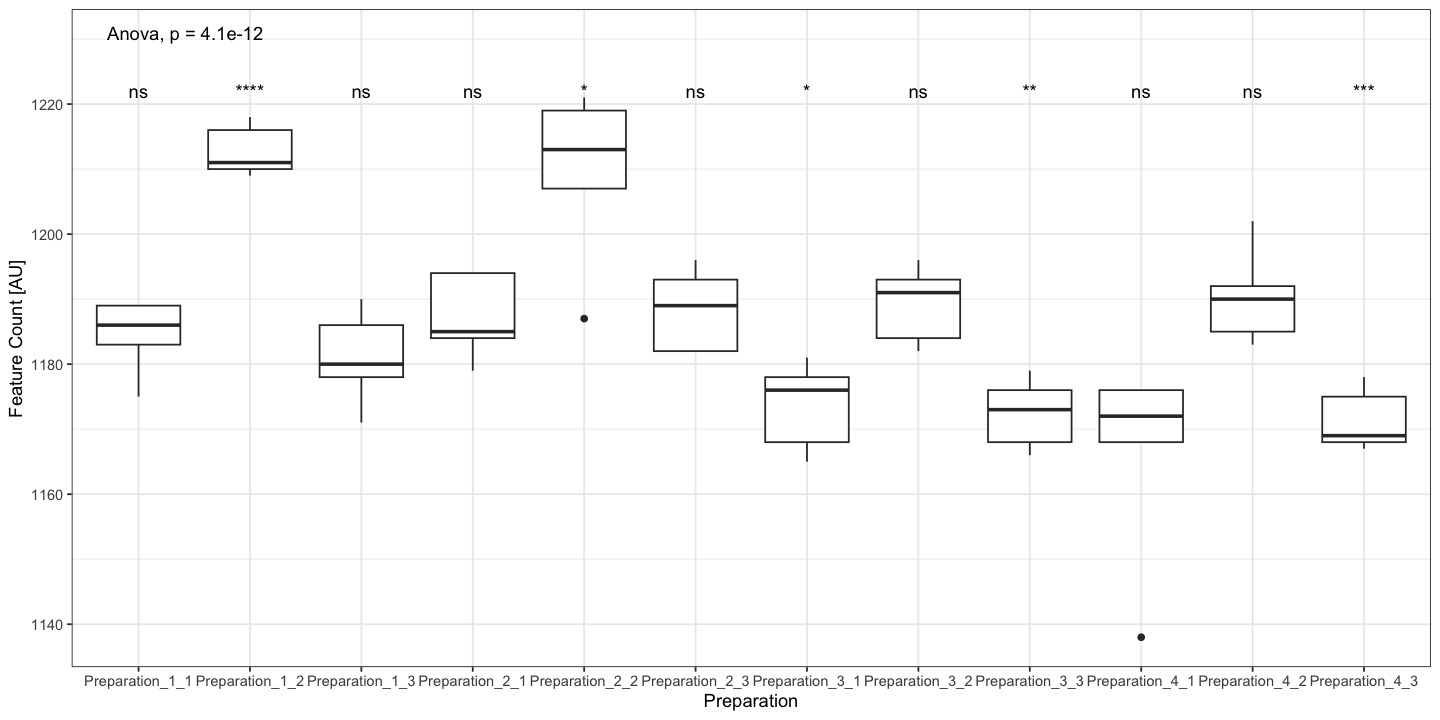

In [77]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1230)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = ".all.") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

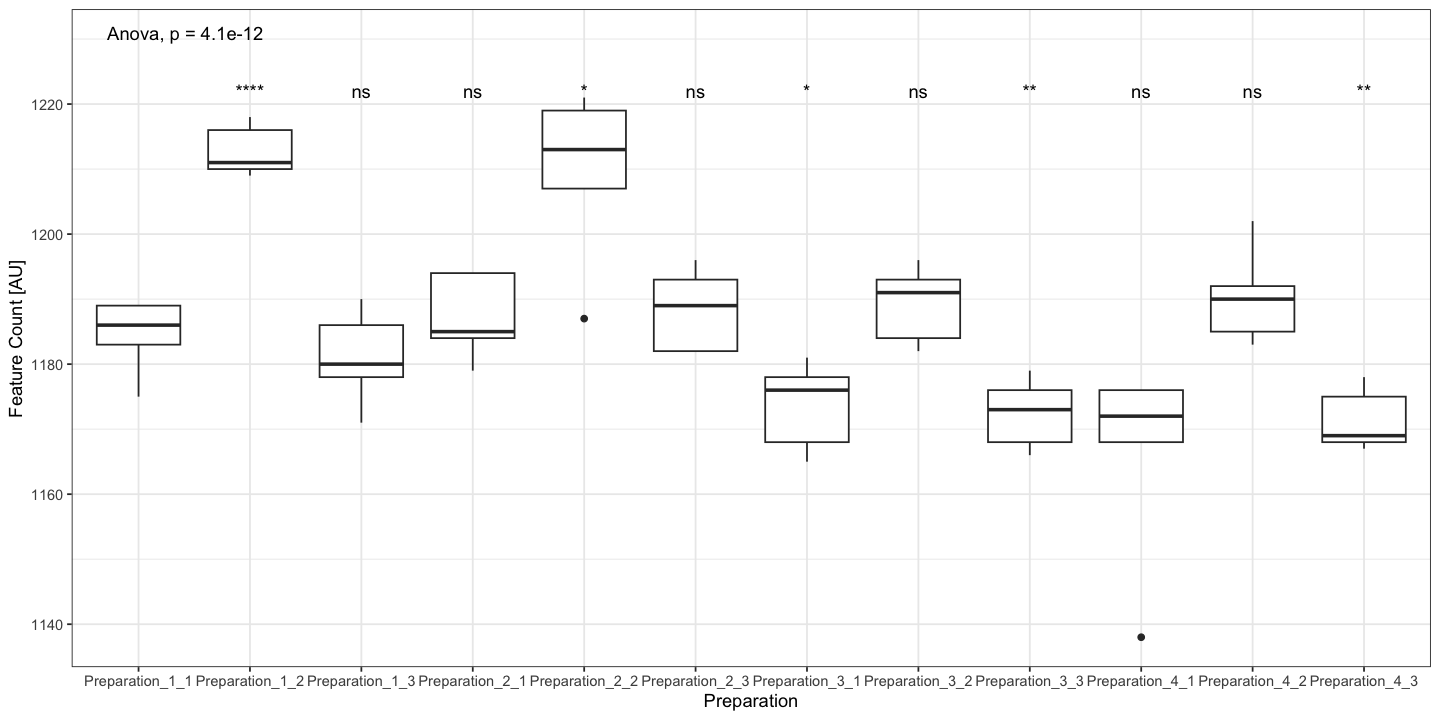

In [78]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1230)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "Preparation_1_1") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

In [79]:
## Export Feature Count Table
Peaknumber_Results <- as.data.frame(count)
colnames(Peaknumber_Results) <- "Feature_count"
Peaknumber_Results$Sample <- rownames(count)
write.csv(Peaknumber_Results, "Feature_Count.csv")

# Feature Count CV<20

In [80]:
Preparation_1_1 <- results[,results$sample_group == "Preparation_1_1"] %>%
               assay("raw")
cv <- apply(Preparation_1_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_1_cv <- cbind(Preparation_1_1,c(cv))
Preparation_1_1_cv20 <- Preparation_1_1_cv[which(cv <= 20),]
Preparation_1_1_cv20 <- nrow(Preparation_1_1_cv20)

Preparation_1_2 <- results[,results$sample_group == "Preparation_1_2"] %>%
               assay("raw")
cv <- apply(Preparation_1_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_2_cv <- cbind(Preparation_1_2,c(cv))
Preparation_1_2_cv20 <- Preparation_1_2_cv[which(cv <= 20),]
Preparation_1_2_cv20 <-nrow(Preparation_1_2_cv20)
            
Preparation_1_3 <- results[,results$sample_group == "Preparation_1_3"] %>%
               assay("raw")
cv <- apply(Preparation_1_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_3_cv <- cbind(Preparation_1_3,c(cv))
Preparation_1_3_cv20 <- Preparation_1_3_cv[which(cv <= 20),]
Preparation_1_3_cv20 <- nrow(Preparation_1_3_cv20)
            
Preparation_2_1 <- results[,results$sample_group == "Preparation_2_1"] %>%
               assay("raw")
cv <- apply(Preparation_2_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_1_cv <- cbind(Preparation_2_1,c(cv))
Preparation_2_1_cv20 <- Preparation_2_1_cv[which(cv <= 20),]
Preparation_2_1_cv20 <- nrow(Preparation_2_1_cv20)
            
Preparation_2_2 <- results[,results$sample_group == "Preparation_2_2"] %>%
               assay("raw")
cv <- apply(Preparation_2_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_2_cv <- cbind(Preparation_2_2,c(cv))
Preparation_2_2_cv20 <- Preparation_2_2_cv[which(cv <= 20),]
Preparation_2_2_cv20 <- nrow(Preparation_2_2_cv20)
            
Preparation_2_3 <- results[,results$sample_group == "Preparation_2_3"] %>%
               assay("raw")
cv <- apply(Preparation_2_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_3_cv <- cbind(Preparation_2_3,c(cv))
Preparation_2_3_cv20 <- Preparation_2_3_cv[which(cv <= 20),]
Preparation_2_3_cv20 <- nrow(Preparation_2_3_cv20)
            
Preparation_3_1 <- results[,results$sample_group == "Preparation_3_1"] %>%
               assay("raw")
cv <- apply(Preparation_3_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_1_cv <- cbind(Preparation_3_1,c(cv))
Preparation_3_1_cv20 <- Preparation_3_1_cv[which(cv <= 20),]
Preparation_3_1_cv20 <- nrow(Preparation_3_1_cv20)
            
Preparation_3_2 <- results[,results$sample_group == "Preparation_3_2"] %>%
               assay("raw")
cv <- apply(Preparation_3_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_2_cv <- cbind(Preparation_3_2,c(cv))
Preparation_3_2_cv20 <- Preparation_3_2_cv[which(cv <= 20),]
Preparation_3_2_cv20 <- nrow(Preparation_3_2_cv20)
            
Preparation_3_3 <- results[,results$sample_group == "Preparation_3_3"] %>%
               assay("raw")
cv <- apply(Preparation_3_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_3_cv <- cbind(Preparation_3_3,c(cv))
Preparation_3_3_cv20 <- Preparation_3_3_cv[which(cv <= 20),]
Preparation_3_3_cv20 <- nrow(Preparation_3_3_cv20)
            
Preparation_4_1 <- results[,results$sample_group == "Preparation_4_1"] %>%
               assay("raw")
cv <- apply(Preparation_4_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_1_cv <- cbind(Preparation_4_1,c(cv))
Preparation_4_1_cv20 <- Preparation_4_1_cv[which(cv <= 20),]
Preparation_4_1_cv20 <- nrow(Preparation_4_1_cv20)  
            
Preparation_4_2 <- results[,results$sample_group == "Preparation_4_2"] %>%
               assay("raw")
cv <- apply(Preparation_4_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_2_cv <- cbind(Preparation_4_2,c(cv))
Preparation_4_2_cv20 <- Preparation_4_2_cv[which(cv <= 20),]
Preparation_4_2_cv20 <- nrow(Preparation_4_2_cv20) 
            
Preparation_4_3 <- results[,results$sample_group == "Preparation_4_3"] %>%
               assay("raw")
cv <- apply(Preparation_4_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_3_cv <- cbind(Preparation_4_3,c(cv))
Preparation_4_3_cv20 <- Preparation_4_3_cv[which(cv <= 20),]
Preparation_4_3_cv20 <- nrow(Preparation_4_3_cv20)

In [81]:
Preparation_CV20 <- c("Preparation_1_1" = Preparation_1_1_cv20, "Preparation_1_2" = Preparation_1_2_cv20,
                   "Preparation_1_3" = Preparation_1_3_cv20, "Preparation_2_1" = Preparation_2_1_cv20, 
                   "Preparation_2_2" = Preparation_2_2_cv20, "Preparation_2_3" = Preparation_2_3_cv20,
                   "Preparation_3_1" = Preparation_3_1_cv20, "Preparation_3_2" = Preparation_3_2_cv20,
                   "Preparation_3_3" = Preparation_3_3_cv20, "Preparation_4_1" = Preparation_4_1_cv20, 
                   "Preparation_4_2" = Preparation_4_2_cv20, "Preparation_4_3" = Preparation_4_3_cv20)
preparation <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                      "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                      "Preparation_4_2", "Preparation_4_3")
Preparation_CV20 <- cbind(Preparation_CV20, c(preparation))
Preparation_CV20 <- as.data.frame(Preparation_CV20)

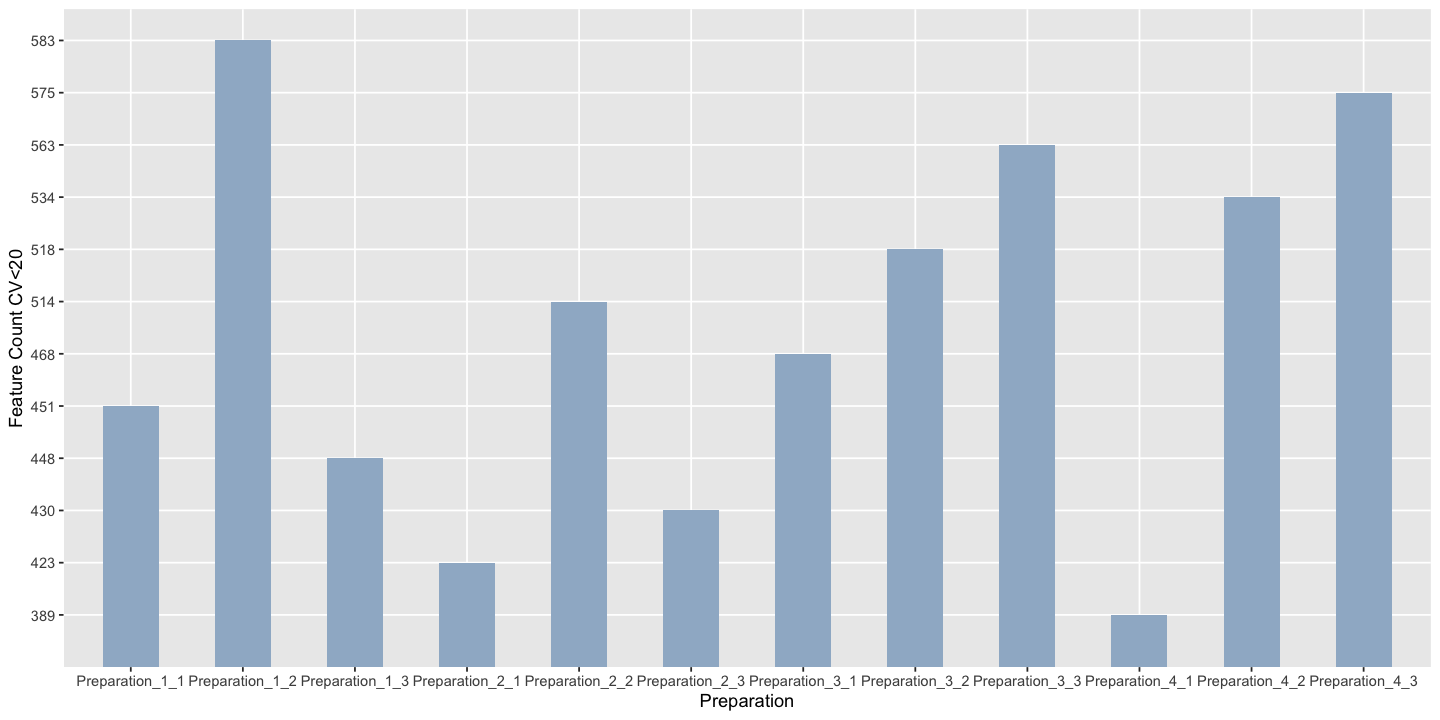

In [82]:
ggplot(Preparation_CV20, aes(preparation, Preparation_CV20))+
geom_col(fill="slategray3", width = 0.5)+
xlab("Preparation") +
ylab("Feature Count CV<20") 

In [83]:
write.csv(Preparation_CV20, "Feature_Count_CV20.csv")

# Summary Images

In [84]:
save.image("Rat_Urine_Extraction_C18_pos_count.RData")

# Appendix

In [85]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.5.0                devtools_2.4.5             
 [3] usethis_2.1.6               writexl_1.4.2              
 [5] ggrepel_0.9.3               MASS_7.3-58.2              
 [7] caret_6.0-93                lattice_0.20-45            
 [9] Rtsne_0.16                  gplots_3.1.3               
[11] forcats_1.0.0               stringr_1.5.0              
[13] dplyr_1.1.0                 purrr_1.0.1                
[15] readr_2.1.4                 tidyr_1.3.0          